In [ ]:
#my modules
import os
os.chdir("..")

from bass_lv_v2 import SVBassLV
from heston import Heston, implied_vol
from utils import Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R
from plot import plot_bass_result

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt

### Create a sample market model

In [6]:
#create the market marginals as an objects with functions from Heston model
model = Heston(s0 = 100, v0 = 0.1, kappa = 2, theta = 0.07, xi = 1, rho = -0.7)
T = [0.25, 0.7, 1]
market_marginal_1 = Density(model.cdf_interpolate(0.25), model.quantile_interpolate(0.25))
market_marginal_2 = Density(model.cdf_interpolate(0.7), model.quantile_interpolate(0.7))
market_marginal_3 = Density(model.cdf_interpolate(1), model.quantile_interpolate(1))

In [8]:
#Create a reference model, which is a Brownian motion in our case
marginals = {0.25: market_marginal_1, 0.7: market_marginal_2, 1: market_marginal_3}
sv_model = BrownianMotion_R(100, 1)
bass = SVBassLV(100, sv_model, marginals)

#calibration example for the Heston market marginals
res = bass.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 5)

Interval 1 (T=0.7): 5 iterations, final error = 0.000617741663929805
Interval 2 (T=1.0): 13 iterations, final error = 0.0008089380806213242


/Users/alexandr/Desktop/bass_lv/bass_lv/heston.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  1/pi * quad(integrand, 0, inf, epsrel=1e-12, epsabs=1e-20)[0])


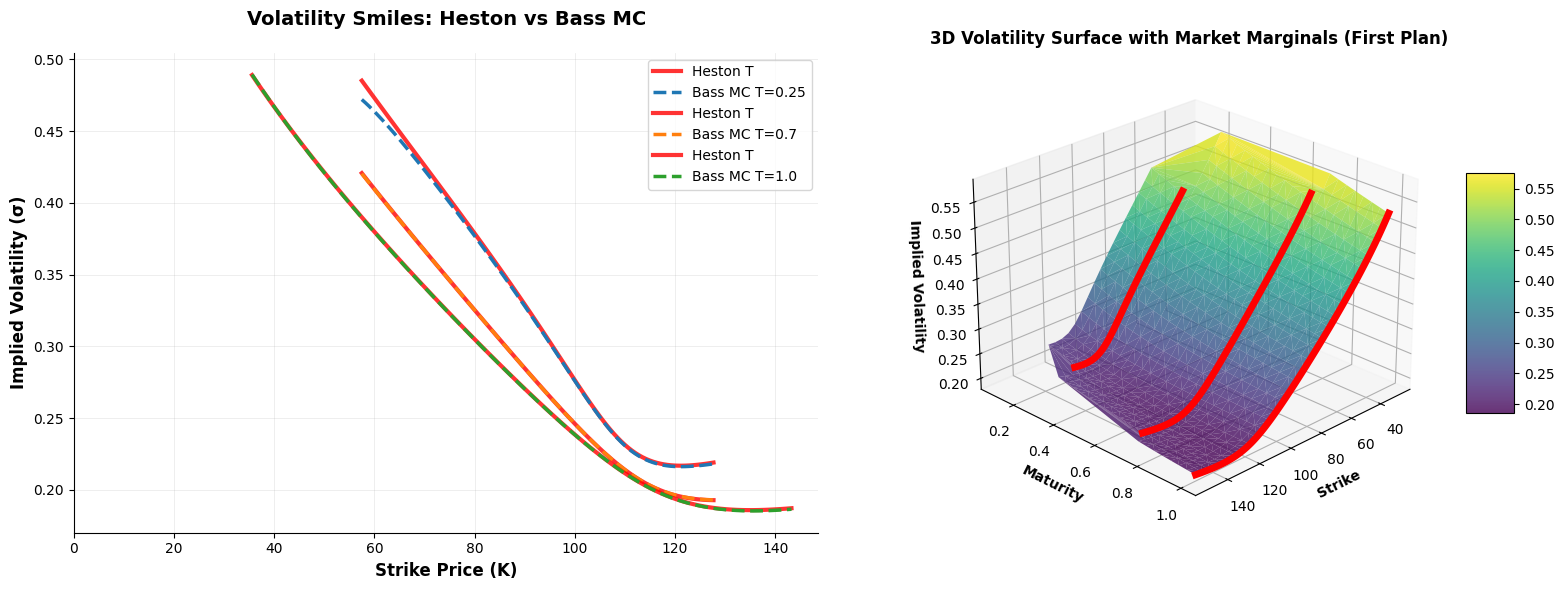

In [ ]:
#Plotting
T_vals = [0.25, 0.7, 1.0] # Only these maturities have model plots
mc_data = {T: bass.simulate_smile(1_000_000, T) for T in T_vals} 
marginals = [market_marginal_1, None, market_marginal_2, None, market_marginal_3]

# Create figure with 3D subplot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)  # 2D plot
ax2 = fig.add_subplot(122, projection='3d')  # 3D surface plot

# 2D Plot with improved readability
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct color palette

for i, T in enumerate(T_vals):
    # Strike range
    marg = marginals[i] or market_marginal_1
    K = np.linspace(marg.qf(0.01), marg.qf(0.99), 100)

    ax1.plot(K, model.implied_vol(T, K), color='red', linestyle='-', linewidth=3, alpha=0.8, label='Heston T')
    ax1.plot(K, mc_iv(model.s0, T, K, mc_data[T]), color=colors[i], linestyle='--', linewidth=2.5, alpha=1, label=f'Bass MC T={T}')

# Improve 2D plot appearance
ax1.set_xlabel('Strike Price (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Implied Volatility (σ)', fontsize=12, fontweight='bold') 
ax1.set_title('Volatility Smiles: Heston vs Bass MC', fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set better axis limits and formatting
ax1.set_xlim(left=0)  # Start from 0 for strikes
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 3D Surface Plot with fixed strike grid, cut off by maturity-specific bounds
# Create fixed strike grid covering all maturities
all_strikes = []
for T, marginal in zip([0.25, 0.7, 1.0], [market_marginal_1, market_marginal_2, market_marginal_3]):
    all_strikes.extend([marginal.qf(0.01), marginal.qf(0.99)])

# Fixed strike range for all maturities
K_min, K_max = min(all_strikes), max(all_strikes)
strikes = np.linspace(K_min, K_max, 30)  # Fixed strike grid
maturities = np.linspace(0.1, 1.0, 25)   # Maturity grid

# Generate surface points with fixed strikes, cut off by maturity bounds
all_points = []
for T in maturities:
    # Find the closest maturity with defined bounds
    if T <= 0.25:
        marginal = market_marginal_1
    elif T <= 0.7:
        marginal = market_marginal_2
    else:
        marginal = market_marginal_3
    
    # Get bounds for this maturity
    K_min_T = marginal.qf(0.01)
    K_max_T = marginal.qf(0.99)
    
    # Filter strikes that fall within this maturity's bounds
    valid_strikes = strikes[(strikes >= K_min_T) & (strikes <= K_max_T)]
    
    for K in valid_strikes:
        try:
            vol = model.implied_vol(T, K)
            if not np.isnan(vol) and vol > 0:
                all_points.append([K, T, vol])
        except:
            continue

# Convert to numpy arrays for triangulation
all_points = np.array(all_points)
if len(all_points) > 0:
    K_valid = all_points[:, 0]
    T_valid = all_points[:, 1]
    vol_valid = all_points[:, 2]
    
    # Create triangulation
    from matplotlib.tri import Triangulation
    triang = Triangulation(K_valid, T_valid)
    
    # Plot triangulated surface using plot_trisurf
    surf = ax2.plot_trisurf(K_valid, T_valid, vol_valid, 
                           triangles=triang.triangles,
                           cmap='viridis', alpha=0.8, 
                           linewidth=0.5, antialiased=True)

# Add market marginals as solid lines on top of the surface (first plan)
for T, marginal in zip([0.25, 0.7, 1.0], [market_marginal_1, market_marginal_2, market_marginal_3]):
    K_range = np.linspace(marginal.qf(0.01), marginal.qf(0.99), 100)  # More points for smooth lines
    vol_line = model.implied_vol(T, K_range)
    
    # Plot the marginal line on top of the 3D surface with thick solid lines
    ax2.plot(K_range, [T] * len(K_range), vol_line, 
             color='red', linewidth=5, alpha=1.0, 
             label=f'Market Marginal T={T}', zorder=10)  # zorder=10 ensures lines are on top

# Customize 3D plot
ax2.set_xlabel('Strike', fontweight='bold')
ax2.set_ylabel('Maturity', fontweight='bold')
ax2.set_zlabel('Implied Volatility', fontweight='bold')
ax2.set_title('3D Volatility Surface with Market Marginals (First Plan)', fontweight='bold')
ax2.view_init(elev=25, azim=45)  # Set viewing angle

# Add colorbar for the surface
if len(all_points) > 0:
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()